# Visual Attention per Area Of Interest

In [44]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import modules.GenSnippetsLib as snippets
from modules import stats as util_stats
from pygments.lexers import PythonLexer
from tqdm.notebook import tqdm
import PIL
import PIL.Image
import numpy as np
from skimage.draw import ellipse
plt.rcParams['savefig.facecolor']='white'

## Load The Data

In [45]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list#

def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [46]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])

df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

## Create the Bounding Boxes of the Areas of Interest

In [47]:
# prepare color mapping for aois
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

color_palette = sns.color_palette("hls", 16)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "RecursiveBaseCase" : color_palette[10],
    "HigherOrder" : color_palette[11],
    "ListComprehension" : color_palette[12],
    "InputPreparation" : color_palette[13],
    "StartOfAlgorithm" : color_palette[14],
    "Class" : color_palette[15],
}
aoi_colors = color_palette
aoi_numbers = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping.items())}
aoi_names = [name for name, _value in color_palette_mapping.items()]

def aoi_idx_to_convoluted_idx(aoi_idx):
    if aoi_idx < 5:
        return aoi_idx
    if 6 <= aoi_idx <= 12:
        return 6
    if 13 <= aoi_idx:
        return aoi_idx-6

def aoi_name_to_convoluted_name(aoi_name):
    if aoi_name in ["Iteration", "IterationHead", "IterationBody",
                    "Recursion", "RecursiveCall", "RecursiveBaseCase",
                    "HigherOrder",
                    "ListComprehension"]:
        return "StyleSpecific"
    return aoi_name

color_palette = sns.color_palette("hls", 10)
color_palette_mapping_convoluted = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "StyleSpecific" : color_palette[6],
    "InputPreparation" : color_palette[7],
    "StartOfAlgorithm" : color_palette[8],
    "Class" : color_palette[9],
}
aoi_colors_convoluted = color_palette
aoi_numbers_convoluted = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping_convoluted.items())}
aoi_names_convoluted = [name for name, _value in color_palette_mapping_convoluted.items()]

In [48]:
# create bounding boxes and visualize them
def from_canvas(fig):
    lst = list(fig.canvas.get_width_height())
    lst.append(3)
    return PIL.Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(),dtype=np.uint8).reshape(lst))

df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
font_path="\\data\\fonts\\ttf\\"
offset = 3


for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box = df_bounding_box.append(pd.DataFrame([[algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]], columns=df_bounding_box.columns))
df_bounding_box

  0%|          | 0/11 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,BoundingBoxes,ImageDimension
0,LinkedList,higher-order,"[(InputPreparation, [2, 811, 152, 1141]), (Met...","(594, 1206)"
0,LinkedList,iterative,"[(Iteration, [2, 603, 344, 673]), (InputPrepar...","(362, 1154)"
0,LinkedList,list-comprehension,"[(InputPreparation, [2, 837, 152, 1167]), (Met...","(706, 1232)"
0,LinkedList,recursive,"[(InputPreparation, [2, 473, 152, 803]), (Meth...","(506, 868)"
0,apply,higher-order,"[(InputPreparation, [2, 109, 392, 130]), (Meth...","(394, 166)"
0,apply,iterative,"[(Iteration, [2, 58, 280, 104]), (InputPrepara...","(394, 244)"
0,apply,list-comprehension,"[(InputPreparation, [2, 109, 392, 130]), (Meth...","(394, 166)"
0,apply,recursive,"[(InputPreparation, [2, 187, 392, 208]), (Meth...","(562, 244)"
0,computer,higher-order,"[(InputPreparation, [2, 473, 576, 676]), (Meth...","(882, 738)"
0,computer,iterative,"[(Iteration, [2, 422, 736, 494]), (InputPrepar...","(738, 842)"


## Map the Visual Attention Measures to the Areas of Interest

In [49]:
def get_ellipse_mask(center, x_radius, y_radius, dimension, std_value = 1.0):
    """
    Returns a mask of an ellipse with the given center, x-radius, and y-radius.
    """
    x_dim = max(center[0]+2*x_radius+1, dimension[0])
    y_dim = max(center[1]+2*y_radius+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    rr, cc = ellipse(center[1], center[0], y_radius, x_radius)
    mask[rr, cc] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

def get_rectangular_mask(points, dimension, std_value = 1.0):
    """
    Returns a mask of a rectangular with the given points.
    """
    x_dim = max(points[2]+1, dimension[0])
    y_dim = max(points[3]+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    mask[points[1]:points[3]+1, points[0]:points[2]+1] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

In [50]:
settings = json.load(open("./data/settings.json"))
x_radius = settings["radius_x"]+settings["grad_radius"]//2
y_radius = settings["radius_y"]+settings["grad_radius"]//2

df = pd.merge(df, df_bounding_box, on=["Algorithm", "ProgrammingStyle"])

In [51]:
df_aoi = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "Number", "Duration", "AOI"])
iteration_categroies = ["Iteration", "IterationHead", "IterationBody"]
recursive_categroies = ["RecursiveCall", "RecursiveBaseCase"]
list_comprehension_categroies = ["ListComprehension"]
higher_order_categroies = ["HigherOrder"]

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    dimension = row["ImageDimension"]
    clicks = row["ClickData"]
    participant = row["ID"]

    duration_per_click = row["TimeData"]
    duration_tmp = [duration_per_click[0]]
    for duration_idx, value in enumerate(duration_per_click):
        if duration_idx == 0:
            continue
        duration_tmp.append(value-duration_per_click[duration_idx-1])
    duration_per_click = duration_tmp

    bounding_boxes = row["BoundingBoxes"]
    mask_bounding_boxes = [get_rectangular_mask(bounding_box, dimension) for _, bounding_box in bounding_boxes]
    names_of_bounding_boxes = [aoi_name for aoi_name, _ in bounding_boxes]

    for idx, (click, duration) in enumerate(zip(clicks, duration_per_click)):
        # get elliptical mask
        click_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
        aois_visited = set()
        # check if the click is in the bounding box of an aoi
        for bounding_box_name, bounding_box_mask in zip(names_of_bounding_boxes, mask_bounding_boxes):
            if np.sum(click_mask*bounding_box_mask) > 0:
                aois_visited.add(bounding_box_name)
        aois_visited_tmp = set()
        for aoi_name in aois_visited:
            if aoi_name in iteration_categroies:
                aois_visited_tmp.add("Iteration")
            elif aoi_name in recursive_categroies:
                aois_visited_tmp.add("Recursion")
            elif aoi_name in list_comprehension_categroies:
                aois_visited_tmp.add("ListComprehension")
            elif aoi_name in higher_order_categroies:
                aois_visited_tmp.add("HigherOrder")
            else:
                aois_visited_tmp.add(aoi_name)
        aois_visited = aois_visited_tmp

        df_aoi.loc[len(df_aoi)] = [algorithm, programming_style, participant, idx, duration, aois_visited]

df_aoi.reset_index(drop=True)
df_aoi

  0%|          | 0/278 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,Participant,Number,Duration,AOI
0,apply,iterative,212,0,10.105,"{StartOfAlgorithm, InputPreparation}"
1,apply,iterative,212,1,24.330,"{MethodBody, Iteration, Method}"
2,apply,iterative,212,2,0.570,"{MethodBody, Iteration, Method}"
3,apply,iterative,212,3,4.187,"{MethodBody, Iteration, Method}"
4,apply,iterative,212,4,7.954,"{Method, MethodDeclaration}"
...,...,...,...,...,...,...
6597,LinkedList,list-comprehension,315,20,3.786,{InputPreparation}
6598,LinkedList,list-comprehension,315,21,0.533,{InputPreparation}
6599,LinkedList,list-comprehension,315,22,0.468,{InputPreparation}
6600,LinkedList,list-comprehension,315,23,0.484,{InputPreparation}


## Metrics

In [52]:
aoi_order = ['Class',
             'Method','MethodDeclaration','MethodBody',
             'Helper','HelperDeclaration','HelperBody',
             'InputPreparation', 'StartOfAlgorithm',
             'StyleSpecific']

In [53]:
df_metrics = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "AOI", "Duration", "Amount"])
for group, df_group in tqdm(df_aoi.groupby(["Algorithm", "ProgrammingStyle", "Participant"])):
    algorithm = group[0]
    programming_style = group[1]
    participant = group[2]

    aoi_duration = {aoi_name : 0.0 for aoi_name in aoi_names_convoluted}
    aoi_amount = {aoi_name : 0 for aoi_name in aoi_names_convoluted}
    for idx, row in df_group.iterrows():
        duration = row["Duration"]
        aois_visited = row["AOI"]
        for aoi_name in aois_visited:
            aoi_name = aoi_name_to_convoluted_name(aoi_name)
            try:
                aoi_duration[aoi_name] += duration
                aoi_amount[aoi_name] += 1
            except:
                print(algorithm, programming_style, participant, aoi_name)
                assert False

    for aoi_name in aoi_names_convoluted:
        df_metrics.loc[len(df_metrics)] = [algorithm, programming_style, participant, aoi_name, aoi_duration[aoi_name], aoi_amount[aoi_name]]
df_metrics["Amount"] = df_metrics["Amount"].astype(float)
df_metrics["Duration"] = df_metrics["Duration"].astype(float)
df_metrics

  0%|          | 0/278 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount
0,LinkedList,higher-order,204,Method,25.186,8.0
1,LinkedList,higher-order,204,MethodDeclaration,12.515,3.0
2,LinkedList,higher-order,204,MethodBody,21.321,7.0
3,LinkedList,higher-order,204,Helper,0.000,0.0
4,LinkedList,higher-order,204,HelperDeclaration,0.000,0.0
...,...,...,...,...,...,...
2775,store,recursive,320,HelperBody,29.130,19.0
2776,store,recursive,320,StyleSpecific,39.201,25.0
2777,store,recursive,320,InputPreparation,27.612,20.0
2778,store,recursive,320,StartOfAlgorithm,0.832,1.0


In [55]:
order=["iterative", "recursive", "higher-order", "list-comprehension"]
df_metrics["Order"] = df_metrics["ProgrammingStyle"].apply(lambda x: order.index(x))
df_metrics = df_metrics.sort_values(by=["Order", "Algorithm"])
df_metrics

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount,Order
76,LinkedList,iterative,294,StyleSpecific,23.721,11.0,0
75,LinkedList,iterative,294,HelperBody,0.000,0.0,0
74,LinkedList,iterative,294,HelperDeclaration,0.000,0.0,0
73,LinkedList,iterative,294,Helper,0.000,0.0,0
72,LinkedList,iterative,294,MethodBody,29.593,14.0,0
...,...,...,...,...,...,...,...
2664,store,list-comprehension,195,HelperDeclaration,0.000,0.0,3
2663,store,list-comprehension,195,Helper,0.000,0.0,3
2662,store,list-comprehension,195,MethodBody,4.737,9.0,3
2661,store,list-comprehension,195,MethodDeclaration,1.747,2.0,3


## Descriptive: Number Of Clicks per AOI

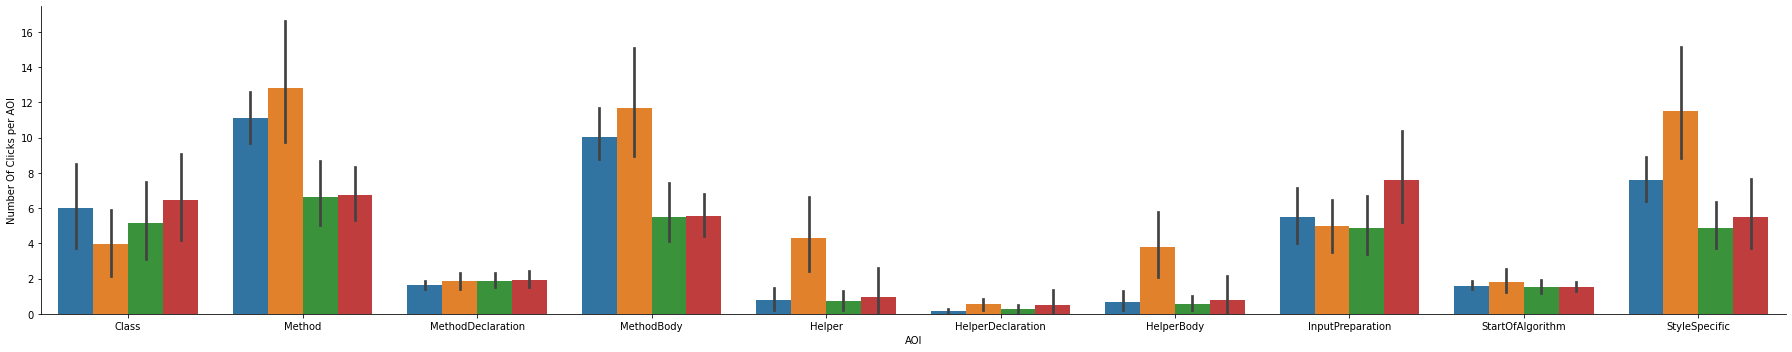

In [63]:
df_tmp = df_metrics.copy()

ax = sns.catplot(x="AOI", y="Amount", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order, legend=False)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks per AOI')
plt.savefig("./results/RQ2/figures/RQ2_NumberOfClicks_PerAOI.png")
plt.show()
plt.close('all')

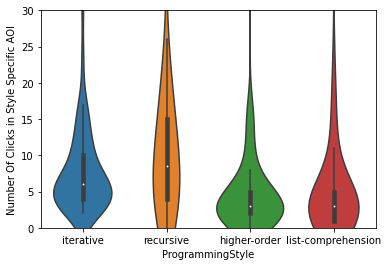

In [57]:
df_total = df_metrics.copy()
df_total["Amount"] = df_total["Amount"].astype(float)
df_total = df_total[df_total["AOI"] == "StyleSpecific"]
ax = sns.violinplot(x="ProgrammingStyle", y="Amount", data=df_total,
                    order=["iterative", "recursive", "higher-order", "list-comprehension"])
ax.set_ylabel('Number Of Clicks in Style Specific AOI')
ax.set(ylim=(0.0, 30.0))
plt.savefig("./results/RQ2/figures/RQ2_NumberOfClicks_PerStyleSpecific.png")
plt.show()
plt.close('all')

## Descriptive: Time Of Clicks per AOI

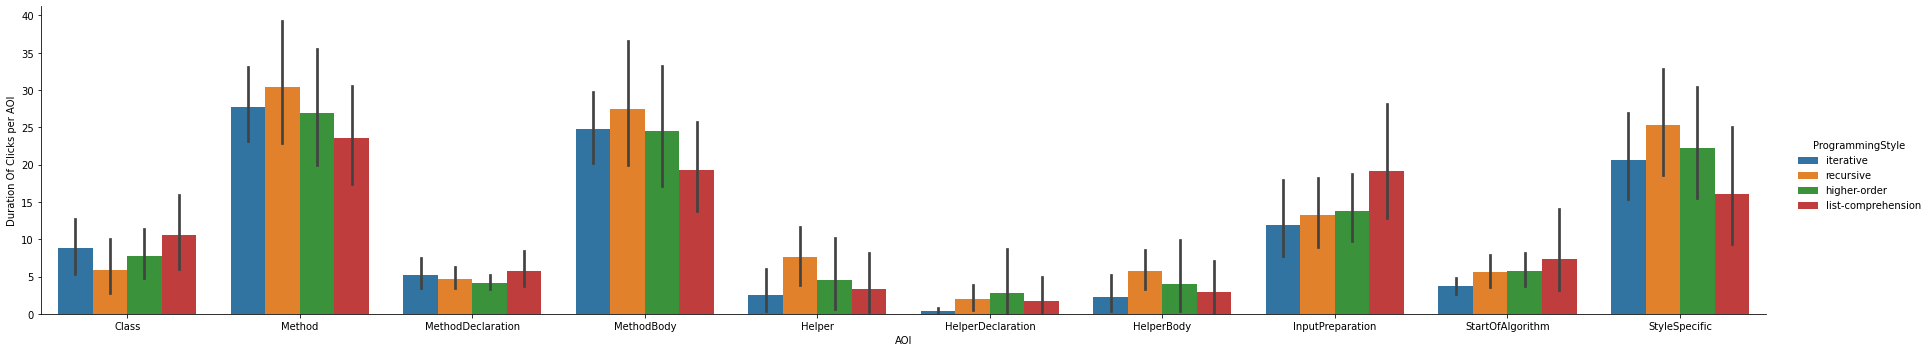

In [58]:
df_total = df_metrics

ax = sns.catplot(x="AOI", y="Duration", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5,
                 aspect=5, hue_order=["iterative", "recursive", "higher-order", "list-comprehension"],
                 order=aoi_order)
ax.tight_layout()
ax.set(ylabel='Duration Of Clicks per AOI')
plt.savefig("./results/RQ2/figures/RQ2_TimeOfClicks_PerAOI.png")
plt.show()
plt.close('all')

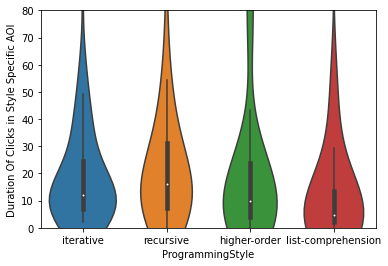

In [59]:
df_total = df_metrics
df_total = df_total[df_total["AOI"] == "StyleSpecific"]
ax = sns.violinplot(x="ProgrammingStyle", y="Duration", data=df_total,
                    order=["iterative", "recursive", "higher-order", "list-comprehension"])
ax.set_ylabel('Duration Of Clicks in Style Specific AOI')
ax.set(ylim=(0.0, 80.0))
plt.savefig("./results/RQ2/figures/RQ2_TimeOfClicks_PerStyleSpecific.png")
plt.show()
plt.close('all')

In [60]:
df_metrics

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount,Order
76,LinkedList,iterative,294,StyleSpecific,23.721,11.0,0
75,LinkedList,iterative,294,HelperBody,0.000,0.0,0
74,LinkedList,iterative,294,HelperDeclaration,0.000,0.0,0
73,LinkedList,iterative,294,Helper,0.000,0.0,0
72,LinkedList,iterative,294,MethodBody,29.593,14.0,0
...,...,...,...,...,...,...,...
2664,store,list-comprehension,195,HelperDeclaration,0.000,0.0,3
2663,store,list-comprehension,195,Helper,0.000,0.0,3
2662,store,list-comprehension,195,MethodBody,4.737,9.0,3
2661,store,list-comprehension,195,MethodDeclaration,1.747,2.0,3


In [61]:
df_sub = df_metrics.copy()
df_sub = df_sub.groupby(["ProgrammingStyle", "AOI"]).describe()
df_sub = df_sub.reset_index()
styles = ["iterative", "recursive", "higher-order", "list-comprehension"]
aois = df_sub["AOI"].unique()
result = ""
for aoi in aois:
    result += f"{aoi} & "
    df_aoi = df_sub[df_sub["AOI"] == aoi]
    for style in styles:
        df_style = df_aoi[df_aoi["ProgrammingStyle"] == style]
        number_mean = round(df_style[("Amount", "mean")].values[0])
        number_std = round(df_style[("Amount", "std")].values[0])
        time_mean = round(df_style[("Duration", "mean")].values[0], 2)
        time_std = round(df_style[("Duration", "std")].values[0], 2)
        result += f"{number_mean} & {number_std} & {time_mean} & {time_std} & "
    result += "\n"
print(result)

Class & 6 & 10 & 8.81 & 15.5 & 4 & 8 & 5.83 & 15.07 & 5 & 9 & 7.78 & 13.49 & 6 & 11 & 10.58 & 21.65 & 
Helper & 1 & 3 & 2.54 & 12.66 & 4 & 9 & 7.56 & 15.69 & 1 & 2 & 4.58 & 22.62 & 1 & 6 & 3.27 & 17.92 & 
HelperBody & 1 & 2 & 2.19 & 11.96 & 4 & 8 & 5.71 & 11.16 & 1 & 2 & 3.99 & 21.24 & 1 & 5 & 2.88 & 15.73 & 
HelperDeclaration & 0 & 0 & 0.38 & 1.36 & 1 & 1 & 2.0 & 7.21 & 0 & 1 & 2.8 & 17.84 & 1 & 3 & 1.69 & 12.26 & 
InputPreparation & 6 & 7 & 11.94 & 21.53 & 5 & 7 & 13.21 & 19.97 & 5 & 7 & 13.74 & 19.59 & 8 & 11 & 19.15 & 32.28 & 
Method & 11 & 7 & 27.72 & 21.29 & 13 & 14 & 30.46 & 35.29 & 7 & 8 & 26.96 & 33.25 & 7 & 6 & 23.56 & 28.58 & 
MethodBody & 10 & 6 & 24.79 & 20.46 & 12 & 13 & 27.43 & 34.5 & 6 & 7 & 24.55 & 33.22 & 6 & 6 & 19.33 & 26.51 & 
MethodDeclaration & 2 & 1 & 5.27 & 9.12 & 2 & 2 & 4.7 & 6.03 & 2 & 2 & 4.17 & 4.19 & 2 & 2 & 5.75 & 10.18 & 
StartOfAlgorithm & 2 & 1 & 3.66 & 4.89 & 2 & 3 & 5.67 & 9.29 & 2 & 2 & 5.74 & 9.78 & 2 & 1 & 7.32 & 24.93 & 
StyleSpecific & 8 & 5 & 

## Inferential Statistics

In [64]:
data = ["iterative", "recursive", "higher-order", "list-comprehension"]
df_metrics["Order"] = df_metrics["ProgrammingStyle"].apply(lambda x: data.index(x))
df_metrics = df_metrics.sort_values(by=["Order", "Algorithm"])
df_metrics

,Algorithm,ProgrammingStyle,Participant,AOI,Duration,Amount,Order
76,LinkedList,iterative,294,StyleSpecific,23.721,11.0,0
75,LinkedList,iterative,294,HelperBody,0.000,0.0,0
74,LinkedList,iterative,294,HelperDeclaration,0.000,0.0,0
73,LinkedList,iterative,294,Helper,0.000,0.0,0
72,LinkedList,iterative,294,MethodBody,29.593,14.0,0
...,...,...,...,...,...,...,...
2664,store,list-comprehension,195,HelperDeclaration,0.000,0.0,3
2663,store,list-comprehension,195,Helper,0.000,0.0,3
2662,store,list-comprehension,195,MethodBody,4.737,9.0,3
2661,store,list-comprehension,195,MethodDeclaration,1.747,2.0,3


In [67]:
df_result_p = df_metrics.copy()
df_result_p = df_result_p[df_result_p["AOI"] == "StyleSpecific"]
df_result_p = util_stats.mannwhitneyu_for_df(df_result_p, "ProgrammingStyle", "Amount")

df_result_e = df_metrics.copy()
df_result_e = df_result_e[df_result_e["AOI"] == "StyleSpecific"]
df_result_e = util_stats.effectsize_for_df(df_result_e, "ProgrammingStyle", "Amount")

df_result_number = df_result_p.merge(df_result_e, on=["Categorie_A", "Categorie_B"])
df_result_number = df_result_number.round(decimals=5)
df_result_number.to_excel("results/RQ2/data/RQ2_NumberOfClicks_PerStyleSpecific_Stats.xlsx", index=False)
df_result_number

,Categorie_A,Categorie_B,p_value,Significant,Effect_Size,Effect_Size_Interpretation
0,iterative,recursive,3.989689e-02,False,-0.171581,small
1,iterative,higher-order,2.873376e-06,True,0.437916,medium
2,iterative,list-comprehension,1.226062e-06,True,0.454563,medium
3,recursive,higher-order,7.449618e-07,True,0.478700,large
4,recursive,list-comprehension,6.360547e-07,True,0.481116,large
5,higher-order,list-comprehension,3.888949e-01,False,0.027725,negligible


In [40]:
categories_a = df_result_number["Categorie_A"].unique()
categories_b = df_result_number["Categorie_B"].unique()
result = ""
for category in categories_a:
    result += f"{category} & "
    df_category = df_result_number[df_result_number["Categorie_A"] == category]
    for column in categories_b:
        df_sub = df_category[df_category["Categorie_B"] == column]
        if len(df_sub) == 0:
            result += "& & & & "
            continue
        p_value = df_sub["p_value"].values[0]
        significance = "*" if df_sub["Significant"].values[0] else ""
        effect_size = df_sub["Effect_Size"].values[0]
        effect_interpretation = df_sub["Effect_Size_Interpretation"].values[0]
        result += f"{p_value} & {significance} & {effect_size} & {effect_interpretation} & "
    result += "\n"
print(result)

iterative & 0.04 &  & -0.172 & small & 0.0 & * & 0.438 & medium & 0.0 & * & 0.455 & medium & 
recursive & & & & & 0.0 & * & 0.479 & large & 0.0 & * & 0.481 & large & 
higher-order & & & & & & & & & 0.389 &  & 0.028 & negligible & 



In [42]:
df_result_p = df_metrics.copy()
df_result_p = df_result_p[df_result_p["AOI"] == "StyleSpecific"]
df_result_p = util_stats.mannwhitneyu_for_df(df_result_p, "ProgrammingStyle", "Duration")

df_result_e = df_metrics.copy()
df_result_e = df_result_e[df_result_e["AOI"] == "StyleSpecific"]
df_result_e = util_stats.effectsize_for_df(df_result_e, "ProgrammingStyle", "Duration")

df_result_time = df_result_p.merge(df_result_e, on=["Categorie_A", "Categorie_B"])
df_result_time = df_result_time.round(decimals=3)
df_result_time.to_excel("results/RQ2/data/RQ2_TimeOfClicks_PerStyleSpecific_Stats.xlsx", index=False)
df_result_time

,Categorie_A,Categorie_B,p_value,Significant,Effect_Size,Effect_Size_Interpretation
0,iterative,recursive,0.186,False,-0.088,negligible
1,iterative,higher-order,0.069,False,0.144,negligible
2,iterative,list-comprehension,0.000,True,0.405,medium
3,recursive,higher-order,0.034,False,0.183,small
4,recursive,list-comprehension,0.000,True,0.386,medium
5,higher-order,list-comprehension,0.028,False,0.188,small


In [43]:
categories_a = df_result_time["Categorie_A"].unique()
categories_b = df_result_time["Categorie_B"].unique()
result = ""
for category in categories_a:
    result += f"{category} & "
    df_category = df_result_time[df_result_time["Categorie_A"] == category]
    for column in categories_b:
        df_sub = df_category[df_category["Categorie_B"] == column]
        if len(df_sub) == 0:
            result += "& & & & "
            continue
        p_value = df_sub["p_value"].values[0]
        significance = "*" if df_sub["Significant"].values[0] else ""
        effect_size = df_sub["Effect_Size"].values[0]
        effect_interpretation = df_sub["Effect_Size_Interpretation"].values[0]
        result += f"{p_value} & {significance} & {effect_size} & {effect_interpretation} & "
    result += "\n"
print(result)

iterative & 0.186 &  & -0.088 & negligible & 0.069 &  & 0.144 & negligible & 0.0 & * & 0.405 & medium & 
recursive & & & & & 0.034 &  & 0.183 & small & 0.0 & * & 0.386 & medium & 
higher-order & & & & & & & & & 0.028 &  & 0.188 & small & 



## Correlations

### Load Demographics

In [18]:
variable_mapping = {
    "CASE" : "ID",
    "ST04_01" : "C++",
    "ST04_02" : "Java",
    "ST04_03" : "Haskell",
    "ST04_04" : "Python",
    "ST04_05" : "Prolog",
    "ST04_06" : "Rust",
    "ST04_07" : "Kotlin",
    "ST05_01" : "Logical",
    "ST05_02" : "Imperative",
    "ST05_03" : "Functional",
    "ST05_04" : "ObjectOriented",
    "ST12" : "Iteration",
    "ST13" : "Recursion",
    "ST14" : "HigherOrder",
    "ST15" : "ListComprehension",
}

df_demographics = pd.read_csv('./data/preprocessed_total_data.csv')
df_demographics = df_demographics[variable_mapping.keys()]
df_demographics.columns = variable_mapping.values()
df_language = df_demographics.melt(id_vars="ID", value_vars=["C++", "Java", "Haskell", "Python", "Prolog", "Rust", "Kotlin"], value_name="PreExperience", var_name="Language")
df_paradigm = df_demographics.melt(id_vars="ID", value_vars=["Logical", "Imperative", "Functional", "ObjectOriented"], value_name="PreExperience", var_name="Paradigm")
df_style = df_demographics.melt(id_vars="ID", value_vars=["Iteration", "Recursion", "HigherOrder", "ListComprehension"], value_name="PreExperience", var_name="Style")

In [19]:
df_tmp = df_metrics[df_metrics["AOI"] == "StyleSpecific"]
df_tmp = df_tmp.rename({"Participant" : "ID"}, axis=1)
df_tmp = df_tmp.merge(df_demographics, on="ID")
df_tmp = df_tmp[["ProgrammingStyle", "Amount", "Iteration", "Recursion", "HigherOrder", "ListComprehension"]]
df_tmp["Amount"] = df_tmp["Amount"].astype(float)
df_correlation = util_stats.correlations_for_df(df_tmp, "ProgrammingStyle", df_tmp.columns[2:], "Amount")
df_correlation = df_correlation.round(3)
df_correlation.to_excel("./results/RQ2/data/RQ2_NumberOfCLicks_PerStyleSpecific_Correlation.xlsx", index=False)
df_correlation

,ProgrammingStyle,PreExperience,Correlation
0,higher-order,Iteration,-0.155
1,iterative,Iteration,0.070
2,list-comprehension,Iteration,0.030
3,recursive,Iteration,0.163
4,higher-order,Recursion,-0.138
5,iterative,Recursion,0.004
6,list-comprehension,Recursion,0.009
7,recursive,Recursion,-0.060
8,higher-order,HigherOrder,-0.116
9,iterative,HigherOrder,0.092


In [20]:
df_tmp = df_metrics[df_metrics["AOI"] == "StyleSpecific"]
df_tmp = df_tmp.rename({"Participant" : "ID"}, axis=1)
df_tmp = df_tmp.merge(df_demographics, on="ID")
df_tmp = df_tmp[["ProgrammingStyle", "Duration", "Iteration", "Recursion", "HigherOrder", "ListComprehension"]]
df_correlation = util_stats.correlations_for_df(df_tmp, "ProgrammingStyle", df_tmp.columns[2:], "Duration")
df_correlation = df_correlation.round(3)
df_correlation.to_excel("./results/RQ2/data/RQ2_TimeOfCLicks_PerStyleSpecific_Correlation.xlsx", index=False)
df_correlation

,ProgrammingStyle,PreExperience,Correlation
0,higher-order,Iteration,-0.328
1,iterative,Iteration,-0.134
2,list-comprehension,Iteration,-0.133
3,recursive,Iteration,0.109
4,higher-order,Recursion,-0.132
5,iterative,Recursion,-0.238
6,list-comprehension,Recursion,-0.030
7,recursive,Recursion,-0.146
8,higher-order,HigherOrder,-0.085
9,iterative,HigherOrder,-0.072
